<a href="https://colab.research.google.com/github/zlkhyr/NllbNusaX/blob/main/NllbClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !pip install datasets
!pip install torchinfo

#Library

In [1]:
import torch
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from torch.optim import AdamW
from google.colab import files
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split
# from datasets import load_dataset, concatenate_datasets
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer
)

#Load Nllb

In [2]:
model_name = "facebook/nllb-200-distilled-600M"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [ ]:
model

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
    (encoder): M2M100Encoder(
      (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
       

#test tokenizer

In [ ]:
token = tokenizer.encode('ini adalah contoh teks' )
token

[256047, 1432, 3276, 43780, 57676, 2]

In [ ]:
tokenizer.convert_ids_to_tokens(token)

['eng_Latn', '▁ini', '▁adalah', '▁contoh', '▁teks', '</s>']

#Data Preporocessing

In [7]:
train = pd.read_csv('/content/drive/MyDrive/Final_Year/data_train.csv')
val = pd.read_csv('/content/drive/MyDrive/Final_Year/data_val.csv')
test = pd.read_csv('/content/drive/MyDrive/Final_Year/data_test.csv')

In [8]:
train.info(), test.info(), val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6000 non-null   object
 1   label   6000 non-null   object
 2   bahasa  6000 non-null   object
dtypes: object(3)
memory usage: 140.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4800 non-null   object
 1   label   4800 non-null   object
 2   bahasa  4800 non-null   object
dtypes: object(3)
memory usage: 112.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1200 non-null   object
 1   label   1200 non-null   object
 2   bahasa  1200 non-null   object
dtypes: object(3)
memory usage: 28.3+ KB


(None, None, None)

In [ ]:
# map_bahasa ={
#   'aceh' : 'ace_Latn',
#   'bali' : 'ban_Latn',
#   'banjar' : 'bjn_Latn',
#   'bugis' : 'bug_Latn',
#   'indonesia' : 'ind_Latn',
#   'inggris' : 'eng_Latn',
#   'jawa' : 'jav_Latn',
#   'minang' : 'min_Latn',
#   'sunda' : 'sun_Latn',

#   'batak toba' : 'ind_Latn',
#   'madura' : 'ind_Latn',
#   'ngaju' : 'ind_Latn'
# }

In [9]:
def preprocess(dataset, shuffle):

  label_map = {"negative": 0, "neutral": 1, "positive": 2}
  dataset["label"] = dataset["label"].map(label_map)

  # tokenizer.src_lang = 'ind_Latn'

  encoding = tokenizer(
      dataset['text'].tolist(),
      padding=True,
      truncation=True,
      max_length=model.config.max_length,
      return_tensors="pt"
  )

  labels = torch.tensor(dataset['label'].tolist(), dtype=torch.long)
  dataset = TensorDataset(encoding['input_ids'], encoding['attention_mask'], labels)
  dataloader = DataLoader(dataset, batch_size=32, shuffle=shuffle)
  return dataloader

In [10]:
train_dataloader = preprocess(train, True)
val_dataloader = preprocess(val, False)

#Pengembangan Model

##Model NllbClassifier

In [11]:
class NllbClassifier(nn.Module):
    def __init__(self, encoder, num_labels=3):
        super().__init__()
        self.encoder = encoder #encoder dari NLLB model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(encoder.config.hidden_size, num_labels)

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, input_ids, attention_mask):
        #Menghapus spesial token di awal tiap text input (language token)
        input_ids = input_ids[:, 1:]
        attention_mask = attention_mask[:, 1:]

        #Forward pass ke encoder
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # Pooling dengan attention_mask
        pooled_output = self.mean_pooling(outputs, attention_mask)

        # Dropout layer
        pooled_output = self.dropout(pooled_output)

        # Classification layer
        logits = self.classifier(pooled_output)

        return logits

#Model

In [12]:
encoder = model.get_encoder()

In [13]:
encoder

M2M100Encoder(
  (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
  (embed_positions): M2M100SinusoidalPositionalEmbedding()
  (layers): ModuleList(
    (0-11): 12 x M2M100EncoderLayer(
      (self_attn): M2M100Attention(
        (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (activation_fn): ReLU()
      (fc1): Linear(in_features=1024, out_features=4096, bias=True)
      (fc2): Linear(in_features=4096, out_features=1024, bias=True)
      (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    )
  )
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In [14]:
modelFT = NllbClassifier(encoder, num_labels=3)

In [17]:
sum(p.numel() for p in modelFT.parameters())

413514755

In [18]:
modelFT

NllbClassifier(
  (encoder): M2M100Encoder(
    (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
    (embed_positions): M2M100SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-11): 12 x M2M100EncoderLayer(
        (self_attn): M2M100Attention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (activation_fn): ReLU()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1024,), eps=1e-05, e

#Freezing



In [26]:
for param in modelFT.encoder.embed_tokens.parameters():
  param.requires_grad = False

#Training

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Code running di: {device}")

Code running di: cuda


In [24]:
modelFT.to(device)

NllbClassifier(
  (encoder): M2M100Encoder(
    (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
    (embed_positions): M2M100SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-11): 12 x M2M100EncoderLayer(
        (self_attn): M2M100Attention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (activation_fn): ReLU()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1024,), eps=1e-05, e

In [25]:
from torchinfo import summary
summary(modelFT)

Layer (type:depth-idx)                                  Param #
NllbClassifier                                          --
├─M2M100Encoder: 1-1                                    --
│    └─M2M100ScaledWordEmbedding: 2-1                   (262,354,944)
│    └─M2M100SinusoidalPositionalEmbedding: 2-2         --
│    └─ModuleList: 2-3                                  --
│    │    └─M2M100EncoderLayer: 3-1                     12,596,224
│    │    └─M2M100EncoderLayer: 3-2                     12,596,224
│    │    └─M2M100EncoderLayer: 3-3                     12,596,224
│    │    └─M2M100EncoderLayer: 3-4                     12,596,224
│    │    └─M2M100EncoderLayer: 3-5                     12,596,224
│    │    └─M2M100EncoderLayer: 3-6                     12,596,224
│    │    └─M2M100EncoderLayer: 3-7                     12,596,224
│    │    └─M2M100EncoderLayer: 3-8                     12,596,224
│    │    └─M2M100EncoderLayer: 3-9                     12,596,224
│    │    └─M2M100EncoderLa

In [28]:
summary(modelFT)

Layer (type:depth-idx)                                  Param #
NllbClassifier                                          --
├─M2M100Encoder: 1-1                                    --
│    └─M2M100ScaledWordEmbedding: 2-1                   262,354,944
│    └─M2M100SinusoidalPositionalEmbedding: 2-2         --
│    └─ModuleList: 2-3                                  --
│    │    └─M2M100EncoderLayer: 3-1                     12,596,224
│    │    └─M2M100EncoderLayer: 3-2                     12,596,224
│    │    └─M2M100EncoderLayer: 3-3                     12,596,224
│    │    └─M2M100EncoderLayer: 3-4                     12,596,224
│    │    └─M2M100EncoderLayer: 3-5                     12,596,224
│    │    └─M2M100EncoderLayer: 3-6                     12,596,224
│    │    └─M2M100EncoderLayer: 3-7                     12,596,224
│    │    └─M2M100EncoderLayer: 3-8                     12,596,224
│    │    └─M2M100EncoderLayer: 3-9                     12,596,224
│    │    └─M2M100EncoderLaye

In [ ]:
optimizer = AdamW(modelFT.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
history = {
        'train_loss':[],
        'val_loss':[],
        'train_acc':[],
        'val_acc':[]
    }

In [ ]:
epochs = 5
for epoch in range(epochs):
        modelFT.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False):
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = modelFT(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = correct_train / total_train
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)

        modelFT.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{epochs} [Validation]", leave=False):
                input_ids, attention_mask, labels = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                outputs = modelFT(input_ids, attention_mask)
                loss = loss_fn(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = correct_val / total_val
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss:{avg_train_loss:.4f}, Validation Loss:{avg_val_loss:.4f}, Accuracy:{train_accuracy:.2f}, Validation Accuracy:{val_accuracy:.2f}")

Epoch [1/5], Loss:0.8338, Validation Loss:0.6978, Accuracy:0.62, Validation Accuracy:0.73


Epoch [2/5], Loss:0.4386, Validation Loss:0.5850, Accuracy:0.84, Validation Accuracy:0.78


Epoch [3/5], Loss:0.2451, Validation Loss:0.7150, Accuracy:0.92, Validation Accuracy:0.78


Epoch [4/5], Loss:0.1427, Validation Loss:0.7912, Accuracy:0.95, Validation Accuracy:0.79


Epoch [5/5], Loss:0.0964, Validation Loss:0.8590, Accuracy:0.97, Validation Accuracy:0.79


#Evaluation

In [ ]:
def learning_curve(history, mode='loss'):
  plt.figure()
  if mode == 'loss':
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
  elif mode == 'acc':
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Learning Curve: {mode}')
  plt.legend()
  plt.grid(True)
  plt.show()

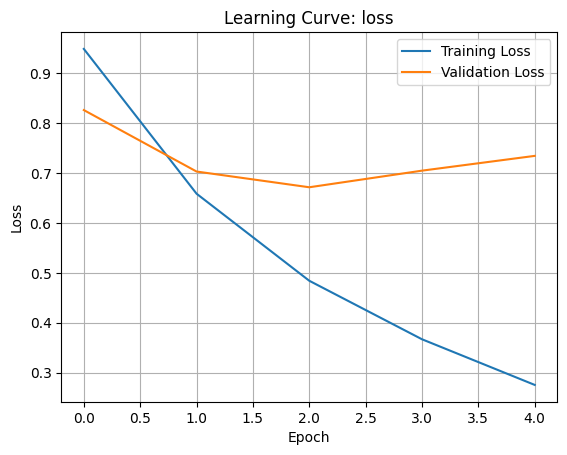

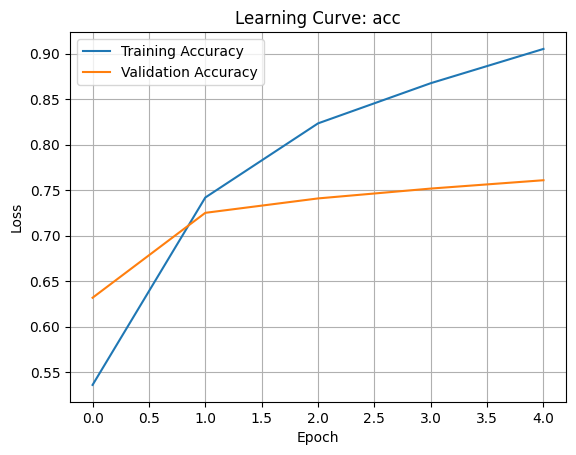

(None, None)

In [ ]:
learning_curve(history, 'loss'), learning_curve(history, mode='acc')

In [ ]:
test_dataloader = preprocess(test, False)

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
  for batch in test_dataloader:
    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    outputs = modelFT(input_ids, attention_mask)
    _, predicted = torch.max(outputs.data, 1)

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

In [ ]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1836
           1       0.75      0.72      0.73      1152
           2       0.84      0.87      0.85      1812

    accuracy                           0.80      4800
   macro avg       0.79      0.79      0.79      4800
weighted avg       0.80      0.80      0.80      4800



#test untuk tiap bahasa

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Final_Year/data_test.csv')

In [ ]:
test_ing = test[test.bahasa == 'aceh']

In [ ]:
test_ing

,text,label,bahasa
0,"Toe ngon hotel lon dom, jak ngon tapak, disino...",positive,aceh
1,"Nyo beutoi, jih teungoh jaga warong.",neutral,aceh
2,On rumpunjih lumayan tapi bieng saos padang cu...,negative,aceh
3,Meuteumpat di braga city walk nyang saboh geud...,positive,aceh
4,Gianjar teurimong bantuan sosial dua ribe lapa...,neutral,aceh
...,...,...,...
395,Lon ka bit kayem pajoh bu di Rumoh Nenek. Lon ...,positive,aceh
396,Le ureueng hana galak jak meuubat bak doto. Pe...,negative,aceh
397,"Pelayanan get, teumpat peudong moto/honda pih ...",positive,aceh
398,"Tes cpns punca macet, paloe",negative,aceh


In [ ]:
test_ing_dataloader = preprocess(test_ing, False)

/tmp/ipython-input-2610284745.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["label"] = dataset["label"].map(label_map)


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
  for batch in test_ing_dataloader:
    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    outputs = modelFT(input_ids, attention_mask)
    _, predicted = torch.max(outputs.data, 1)

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

In [ ]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78       153
           1       0.74      0.73      0.73        96
           2       0.87      0.86      0.87       151

    accuracy                           0.80       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.80      0.80      0.80       400



In [ ]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       153
           1       0.79      0.70      0.74        96
           2       0.81      0.87      0.84       151

    accuracy                           0.80       400
   macro avg       0.79      0.78      0.79       400
weighted avg       0.79      0.80      0.79       400

